In [200]:
from DataParser import DataParser
import numpy as np

In [207]:
import scipy.sparse as sp

In [201]:
data_pars = DataParser('data')

In [202]:
seed = 3001

In [260]:
num_users, num_items, _ = data_pars.get_statistics()
num_users = num_users['max']+1
num_items = num_items['max']+1

Users:
num_users=7947
min_user_id=0
max_user_id=7946

Items:
num_items=24896
min_item_id=0
max_item_id=25974

Ratings:
tot_ratings=339804
sparsity=0.00172


In [261]:
from sklearn.model_selection import train_test_split

def dataset_splits(ratings, num_users, num_items, validation_percentage: float, testing_percentage: float):
    seed = 1234
    
    (user_ids_training, user_ids_test,
     item_ids_training, item_ids_test,
     ratings_training, ratings_test) = train_test_split(ratings.user_id,
                                                        ratings.item_id,
                                                        ratings.ratings,
                                                        test_size=testing_percentage,
                                                        shuffle=True,
                                                        random_state=seed)
    
    (user_ids_training, user_ids_validation,
     item_ids_training, item_ids_validation,
     ratings_training, ratings_validation) = train_test_split(user_ids_training,
                                                              item_ids_training,
                                                              ratings_training,
                                                              test_size=validation_percentage,
                                                             )
    
    urm_train = sp.csr_matrix((ratings_training, (user_ids_training, item_ids_training)), 
                              shape=(num_users, num_items))
    
    urm_validation = sp.csr_matrix((ratings_validation, (user_ids_validation, item_ids_validation)), 
                              shape=(num_users, num_items))
    
    urm_test = sp.csr_matrix((ratings_test, (user_ids_test, item_ids_test)), 
                              shape=(num_users, num_items))
    
    
    
    return urm_train, urm_validation, urm_test

In [262]:
URM_train, URM_validation, URM_test = dataset_splits(data_pars.get_mapped_ratings(), num_users=num_users, num_items=num_items_urm, validation_percentage=0.10, testing_percentage=0.20) 

In [263]:
URM_train

<7947x25975 sparse matrix of type '<class 'numpy.float32'>'
	with 81552 stored elements in Compressed Sparse Row format>

In [264]:
URM_validation

<7947x25975 sparse matrix of type '<class 'numpy.float32'>'
	with 9062 stored elements in Compressed Sparse Row format>

In [265]:
URM_test

<7947x25975 sparse matrix of type '<class 'numpy.float32'>'
	with 22654 stored elements in Compressed Sparse Row format>

In [266]:
item_list = data_pars.get_icm().item_id.to_list()
weight_list = data_pars.get_icm().value.to_list()
feature_list = data_pars.get_icm().feature_id.to_list()

In [267]:
unique_items, unique_features = len(set(item_list)), len(set(feature_list))

In [268]:
num_features = max(feature_list) + 1
num_items = max(item_list) + 1

In [269]:
ICM_shape = (num_items, num_features)
ICM = sp.coo_matrix((weight_list, (item_list, feature_list)), shape=ICM_shape)
ICM = ICM.tocsr()
ICM

<25975x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 490691 stored elements in Compressed Sparse Row format>

In [270]:
items_per_feature = np.array((ICM>0).sum(axis=0)).squeeze()

In [271]:
items_per_feature

array([ 5,  3,  2, ...,  6, 75, 17], dtype=int32)

In [272]:
features_per_item = np.array((ICM>0).sum(axis=1)).squeeze()

In [273]:
features_per_item

array([17,  5, 21, ..., 25, 14, 15])

In [274]:
ICM = sps.csr_matrix(ICM)
features_per_item2 = np.diff(ICM.indptr)

ICM = sps.csc_matrix(ICM)
items_per_feature2 = np.diff(ICM.indptr)

ICM = sps.csr_matrix(ICM)

In [275]:
items_per_feature2, features_per_item2

(array([ 5,  3,  2, ...,  6, 75, 17], dtype=int32),
 array([17,  5, 21, ..., 25, 14, 15], dtype=int32))

In [276]:
items_per_feature = np.sort(items_per_feature)
features_per_item = np.sort(features_per_item)

items_per_feature2 = np.sort(items_per_feature2)
features_per_item2 = np.sort(features_per_item2)

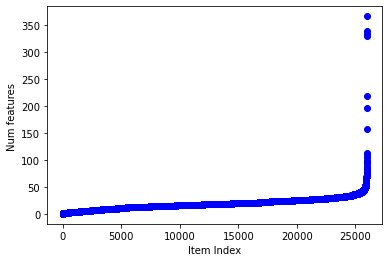

In [277]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item2, 'bo')
pyplot.ylabel('Num features ')
pyplot.xlabel('Item Index')
pyplot.show()

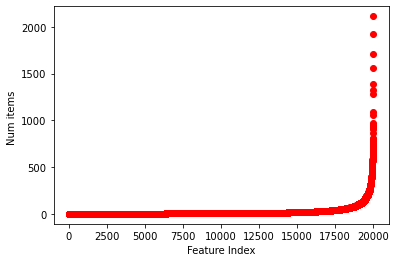

In [278]:
pyplot.plot(items_per_feature2, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Feature Index')
pyplot.show()

In [279]:
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

class ItemKNNContentBasedRec(object):
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
    
    def fit(self, topK, shrink, similarity, normalize):
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, topK=topK, normalize=normalize, similarity=similarity)
        
        self.W_sparse = similarity_object.compute_similarity()
    
    def recommend(self, user_id, at=None, exclude_seen=True):
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()
        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [280]:
recommender = ItemKNNContentBasedRec(URM_train, ICM)
recommender.fit(topK=100, shrink=50.0, similarity='cosine', normalize=True)

Similarity column 25975 ( 100 % ), 1717.18 column/sec, elapsed time 0.25 min


In [281]:
for user_id in list(set(data_pars.get_ratings().user_id.to_list()))[0:10]:
    print(recommender.recommend(user_id, at=5))

[ 7908 13005 14168 24573   413]
[12119  6198 12561  8097  4549]
[14353  1353 11936 18003  2368]
[17510 17174  4750  6253  9462]
[ 5191 13864 12587  3162  7704]
[16172 22517 25285  9301 15150]
[  426 25930  3569 11295 21470]
[17332  4314  8104 13840 20620]
[14059  9316 24317  4044 13091]
[ 3699  1376 15782  5741  8890]


In [282]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

Reasonable implementation speed is 1806.24 usr/sec


In [283]:
def recall(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant) / relevant_items.shape[0]
    
    return recall_score
    
    
def precision(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant) / recommendations.shape[0]

    return precision_score

def mean_average_precision(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    precision_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    map_score = np.sum(precision_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

In [284]:
def evaluator(recommender: object, urm_train: sp.csr_matrix, urm_test: sp.csr_matrix):
    recommendation_length = 10
    accum_precision = 0
    accum_recall = 0
    accum_map = 0
    
    num_users = urm_train.shape[0]
    
    num_users_evaluated = 0
    num_users_skipped = 0
    for user_id in range(num_users):
        user_profile_start = urm_test.indptr[user_id]
        user_profile_end = urm_test.indptr[user_id+1]
        
        relevant_items = urm_test.indices[user_profile_start:user_profile_end]
        
        if relevant_items.size == 0:
            num_users_skipped += 1
            continue
            
        recommendations = recommender.recommend(user_id=user_id, 
                                               at=recommendation_length, 
                                               exclude_seen=True)
        
        accum_precision += precision(recommendations, relevant_items)
        accum_recall += recall(recommendations, relevant_items)
        accum_map += mean_average_precision(recommendations, relevant_items)
        
        num_users_evaluated += 1
        
    
    accum_precision /= max(num_users_evaluated, 1)
    accum_recall /= max(num_users_evaluated, 1)
    accum_map /=  max(num_users_evaluated, 1)
    
    print("Evaluation done\n")
    
    result_dic = {'precision': accum_precision, 'recall': accum_recall, 'MAP': accum_map, 'eval_users': num_users_evaluated, 'skipped_users': num_users_skipped}
    
    return result_dic

In [289]:
x_tick = np.arange(10,1500,100)
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemKNNContentBasedRec(URM_train, ICM)
    recommender.fit(shrink=0.0, topK=topK, normalize = True, similarity = 'cosine')
    
    result_dict = evaluator(recommender, URM_train, URM_test)
    
    MAP_per_k.append(result_dict["MAP"])

Similarity column 25975 ( 100 % ), 1681.37 column/sec, elapsed time 0.26 min
Evaluation done

Similarity column 25975 ( 100 % ), 1641.42 column/sec, elapsed time 0.26 min
Evaluation done

Similarity column 25975 ( 100 % ), 1569.91 column/sec, elapsed time 0.28 min
Evaluation done

Similarity column 25975 ( 100 % ), 1217.43 column/sec, elapsed time 0.36 min
Evaluation done

Similarity column 25975 ( 100 % ), 1335.06 column/sec, elapsed time 0.32 min
Evaluation done

Similarity column 25975 ( 100 % ), 1291.13 column/sec, elapsed time 0.34 min
Evaluation done

Similarity column 25975 ( 100 % ), 1227.38 column/sec, elapsed time 0.35 min
Evaluation done

Similarity column 25975 ( 100 % ), 1214.12 column/sec, elapsed time 0.36 min
Evaluation done

Similarity column 25975 ( 100 % ), 1239.18 column/sec, elapsed time 0.35 min
Evaluation done

Similarity column 25975 ( 100 % ), 1204.01 column/sec, elapsed time 0.36 min
Evaluation done

Similarity column 25975 ( 100 % ), 1145.46 column/sec, elaps

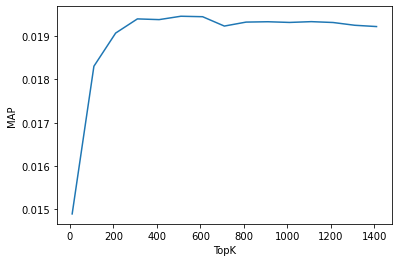

In [290]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

In [296]:
x_tick = np.arange(0,100,5)
MAP_per_shrink = []

for shrink in x_tick:
    
    recommender = ItemKNNContentBasedRec(URM_train, ICM)
    recommender.fit(shrink=shrink, topK=550, normalize = True, similarity = 'cosine')
    
    result_dict = evaluator(recommender, URM_train, URM_test)
    
    MAP_per_shrink.append(result_dict["MAP"])

Similarity column 25975 ( 100 % ), 1338.41 column/sec, elapsed time 0.32 min
Evaluation done

Similarity column 25975 ( 100 % ), 1368.09 column/sec, elapsed time 0.32 min
Evaluation done

Similarity column 25975 ( 100 % ), 1375.43 column/sec, elapsed time 0.31 min
Evaluation done

Similarity column 25975 ( 100 % ), 1383.16 column/sec, elapsed time 0.31 min
Evaluation done

Similarity column 25975 ( 100 % ), 1380.41 column/sec, elapsed time 0.31 min
Evaluation done

Similarity column 25975 ( 100 % ), 1372.31 column/sec, elapsed time 0.32 min
Evaluation done

Similarity column 25975 ( 100 % ), 1377.86 column/sec, elapsed time 0.31 min
Evaluation done

Similarity column 25975 ( 100 % ), 1374.26 column/sec, elapsed time 0.32 min
Evaluation done

Similarity column 25975 ( 100 % ), 1375.51 column/sec, elapsed time 0.31 min
Evaluation done

Similarity column 25975 ( 100 % ), 1304.46 column/sec, elapsed time 0.33 min
Evaluation done

Similarity column 25975 ( 100 % ), 1426.34 column/sec, elaps

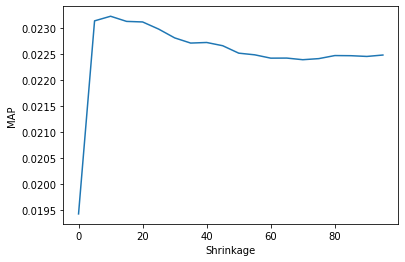

In [297]:
pyplot.plot(x_tick, MAP_per_shrink)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

In [299]:
recommender = ItemKNNContentBasedRec(URM_train, ICM)
recommender.fit(shrink=10, topK=550, normalize = True, similarity = 'cosine')
    
result_dict = evaluator(recommender, URM_train, URM_validation)
result_dict

Similarity column 25975 ( 100 % ), 1376.68 column/sec, elapsed time 0.31 min
Evaluation done



{'precision': 0.009675675675675724,
 'recall': 0.04965296510714923,
 'MAP': 0.020242353961103975,
 'eval_users': 3700,
 'skipped_users': 4247}